# Feature Engineering

In [2]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

from sklearn.feature_selection import mutual_info_classif

%matplotlib inline

In [3]:
# 读取数据
train_idx = pd.read_csv("F:/BaiduNetdiskDownload/train_clean.gz",index_col=0).index
test_idx = pd.read_csv("F:/BaiduNetdiskDownload/test_clean.gz",index_col=0).index

In [4]:
fullset = pd.read_csv("F:/BaiduNetdiskDownload/fullset_update.gz",index_col=0)

In [5]:
train = fullset.loc[train_idx]
test = fullset.loc[test_idx]

In [6]:
from data_management import meta

In [7]:
metadata = meta(train,test)

## Encoding

### LabelEncoder

> Encode target labels with value between 0 and n_classes-1.

### OrdinalEncoder

> Encode categorical features as an integer array.



>
> both have the same functionality. A bit difference is the idea behind. OrdinalEncoder is for converting features, while LabelEncoder is for converting target variable.That's why OrdinalEncoder can fit data that has the shape of `(n_samples, n_features)` while LabelEncoder can only fit data that has the shape of `(n_samples,)` (though in the past one used LabelEncoder within the loop to handle what has been becoming the job of OrdinalEncoder now)



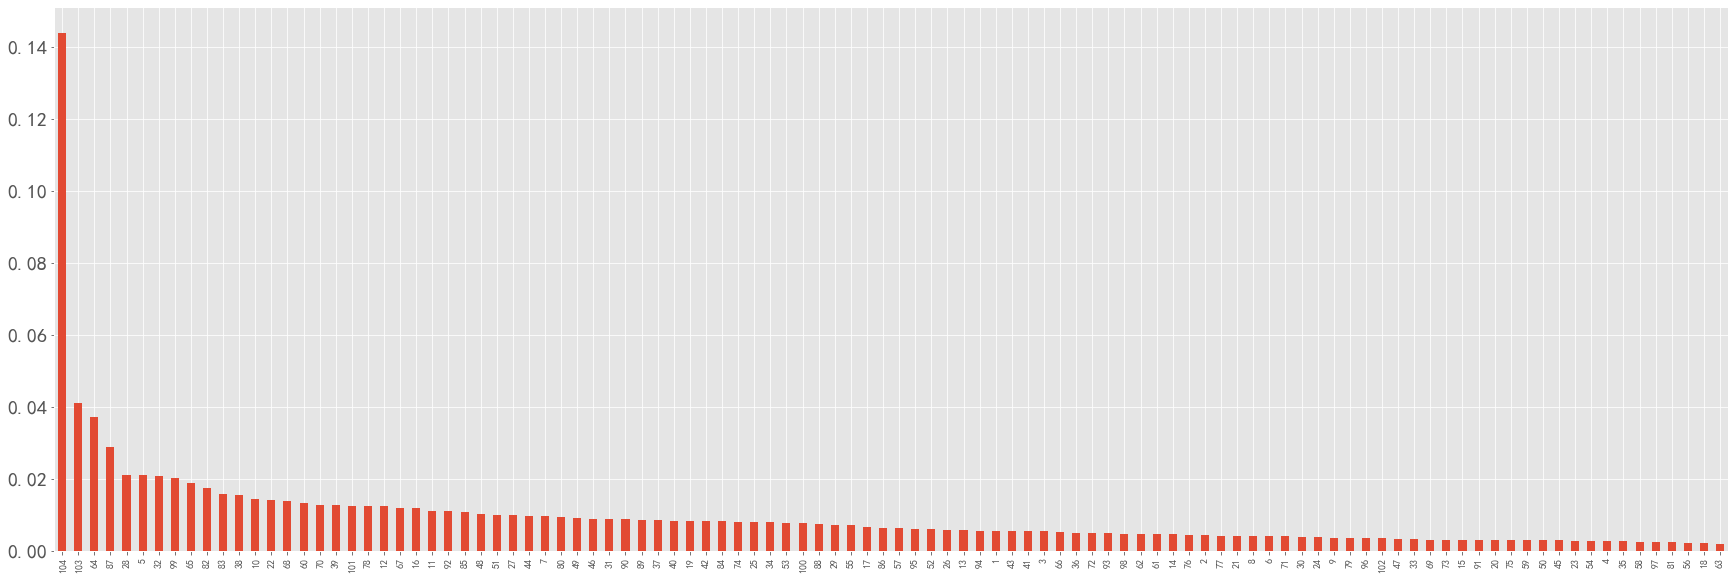

In [8]:
(fullset.ps_car_11_cat.value_counts()/fullset.shape[0]).plot(kind='bar',figsize = [30,10])
plt.tick_params(axis='y', which='major', labelsize=20)

This column is nominal, a discrete variable, and a category of dominant: 104 (although I don't understand what it means), accounting for about 15% of the entire category, so I can't think that this category completely overwhelms other categories, so that it can be Ignore the other categories of studies, and this column has 104 unique value counts, and there is no order relationship.



### OneHotEncoder



In [48]:
nominal_cols = metadata[(metadata.level == 'nominal') & (metadata.keep == True)].index.tolist()
nominal_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [49]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore",sparse=False)
trn_nominal_cols_enc = enc.fit_transform(train[nominal_cols])
tst_nominal_cols_enc = enc.transform(test[nominal_cols])

F:\111\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [50]:
trn_nominal_cols_enc.shape

(144626, 177)

In [51]:
tst_nominal_cols_enc.shape

(892816, 177)

下面来具体看看`OneHotEncoder`怎么使用吧！

In [52]:
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [53]:
# 展示每一类的category
enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [54]:
enc.transform([['Female', 1], ['Male', 4]]).toarray()

array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [55]:
enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

array([['Male', 1],
       [None, 2]], dtype=object)

In [56]:
enc.get_feature_names_out(['gender', 'group'])

array(['gender_Female', 'gender_Male', 'group_1', 'group_2', 'group_3'],
      dtype=object)

In [57]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # 集散这一列关于target的group mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # 平滑
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # 计算所有target的mean
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    # 如果某一类别的值的个数特别多，比如104这一类就有21255行，那么我们就要削减其关于target的mean的权值。
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # 分别对train和test计算mean
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [19]:
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(
    train.drop('target',axis=1), train.target, test_size=0.2, random_state=1996)

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f_cats = [f for f in X_trn.columns if "_cat" in f]

min_samples_leaf = 100
smoothing = 10
noise_level=0.01

print(f"min_samples_leaf:{Fore.BLUE}{min_samples_leaf}{Style.RESET_ALL}\n"
      f"smoothing:{Fore.BLUE}{smoothing}{Style.RESET_ALL}\n"
      f"noise_level:{Fore.BLUE}{noise_level}{Style.RESET_ALL}")

print("-"*100)
print("%20s   %20s  %25s  %22s" % ("", f"{Fore.BLUE}编码前{Style.RESET_ALL}", 
                                   f"{Fore.RED}编码后{Style.RESET_ALL}", 
                                   f"{Fore.GREEN}前后变化{Style.RESET_ALL}"))
for f in f_cats:
    print("%-20s: " % f, end="")
    tf_scores = []
    f_scores = []
    for trn_idx, val_idx in folds.split(X_trn.values, y_trn.values):
        trn_f, trn_tgt = X_trn[f].iloc[trn_idx], y_trn.iloc[trn_idx]
        val_f, val_tgt = X_trn[f].iloc[trn_idx], y_trn.iloc[trn_idx]
        trn_tf, val_tf = target_encode(trn_series=trn_f, 
                                       tst_series=val_f, 
                                       target=trn_tgt, 
                                       min_samples_leaf=min_samples_leaf, 
                                       smoothing=smoothing,
                                       noise_level=noise_level)
        f_scores.append(max(roc_auc_score(val_tgt, val_f), 1 - roc_auc_score(val_tgt, val_f)))
        tf_scores.append(roc_auc_score(val_tgt, val_tf))
    print(" %.6f ± %.6f | %6f ± %.6f | %6f" 
          % (np.mean(f_scores), np.std(f_scores), np.mean(tf_scores), np.std(tf_scores), np.mean(tf_scores)-np.mean(f_scores)))

min_samples_leaf:100
smoothing:10
noise_level:0.01
----------------------------------------------------------------------------------------------------
                               编码前               编码后           前后变化
ps_ind_02_cat       :  0.508104 ± 0.000422 | 0.509292 ± 0.001292 | 0.001187
ps_ind_04_cat       :  0.512504 ± 0.000825 | 0.513234 ± 0.002068 | 0.000731
ps_ind_05_cat       :  0.519149 ± 0.000840 | 0.531978 ± 0.002157 | 0.012829
ps_car_01_cat       :  0.527362 ± 0.000694 | 0.551687 ± 0.001037 | 0.024325
ps_car_02_cat       :  0.532023 ± 0.000185 | 0.530599 ± 0.001411 | -0.001424
ps_car_03_cat       :  0.539585 ± 0.001345 | 0.539474 ± 0.001991 | -0.000112
ps_car_04_cat       :  0.537897 ± 0.000764 | 0.538926 ± 0.001353 | 0.001028
ps_car_05_cat       :  0.531300 ± 0.001056 | 0.531896 ± 0.001345 | 0.000596
ps_car_06_cat       :  0.517316 ± 0.000678 | 0.541439 ± 0.001042 | 0.024123
ps_car_07_cat       :  0.523654 ± 0.000581 | 0.524388 ± 0.002013 | 0.000733
ps_car_08_cat     

In [21]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [22]:
train["ps_car_11_cat_tar_enc"] = train_encoded.astype('float64')
test['ps_car_11_cat_tar_enc'] = test_encoded.astype('float64')

In [23]:
cols_to_drop = metadata[metadata['imputation'] == 'remove'].index.tolist()

In [24]:
cols_to_drop.append('ps_car_11_cat')

In [25]:
train_clean = train.drop(cols_to_drop,axis=1)

In [26]:
test_clean = test.drop(cols_to_drop,axis=1)

In [27]:
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

In [28]:
fullset = pd.concat([train_clean,test_clean],ignore_index=True)

In [29]:
continuous_cols = metadata[(metadata.level == 'interval')|(metadata.level == 'ratio') & (metadata.keep == True)].index.tolist()

<AxesSubplot:>

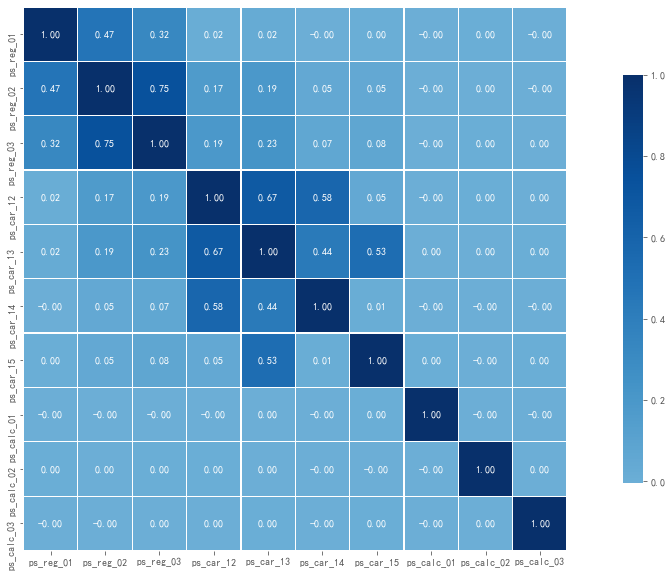

In [30]:
plt.figure(figsize = [20,10])   # 设置画布大小
sns.heatmap(data = fullset[continuous_cols].corr(), 
            vmax=1,
            center=0,
            square=True,
           annot = True,  # 显示文字
          fmt='.2f',      # 保留两位
           cmap = 'Blues',   # 颜色
           linewidths = .3,  # 分割线宽度
           cbar_kws={"shrink": .75})

![](https://miro.medium.com/max/1225/1*MAr4rWj6zw0Rdo01ecZu1A.png)

In [31]:
import pandas as pd
value_list = [0, 10, 20, 59, 61, 79, 80, 90, 99, 100]

# 等频分箱
value_freq_bins = pd.qcut(value_list, q=5)
# 等距分箱
value_dis_bins = pd.cut(value_list, bins=5)

<AxesSubplot:ylabel='Count'>

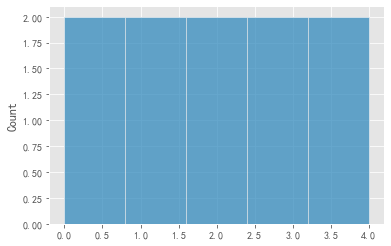

In [33]:
sns.histplot(value_freq_bins.codes)

<AxesSubplot:ylabel='Count'>

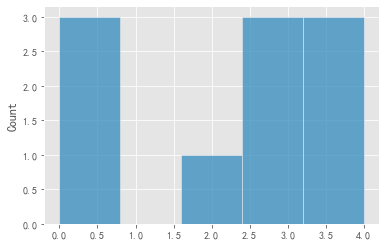

In [34]:
sns.histplot(value_dis_bins.codes)

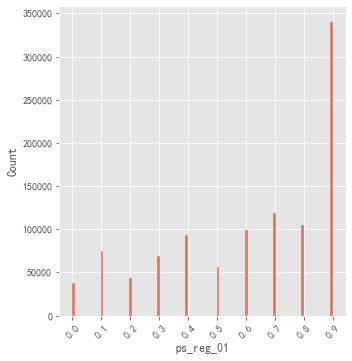

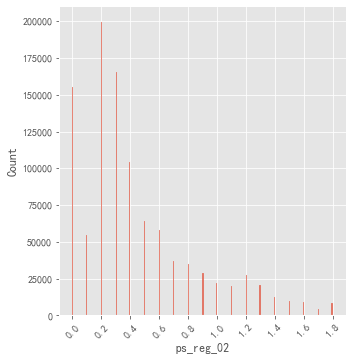

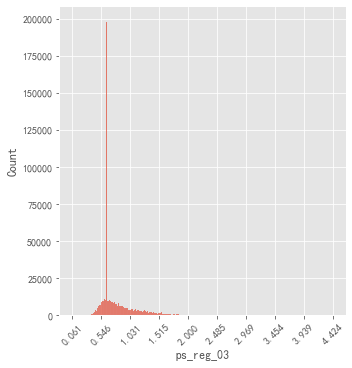

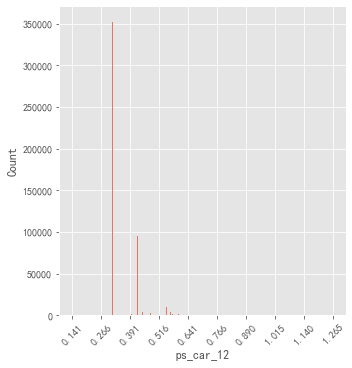

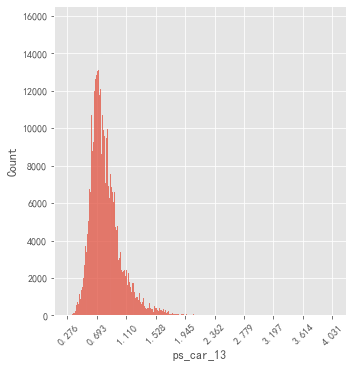

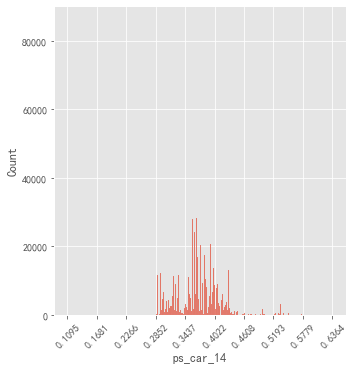

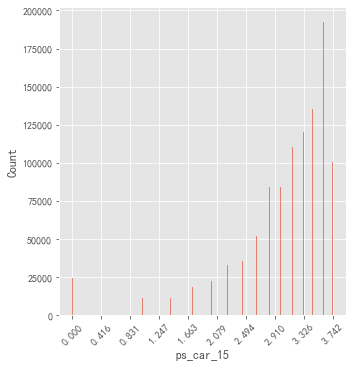

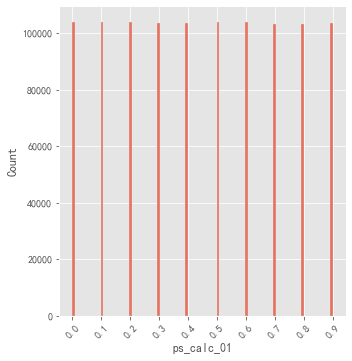

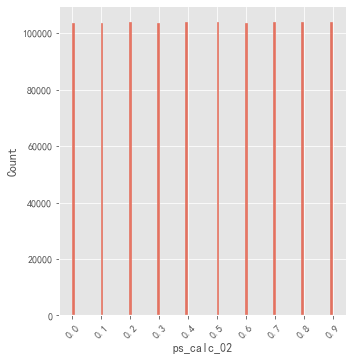

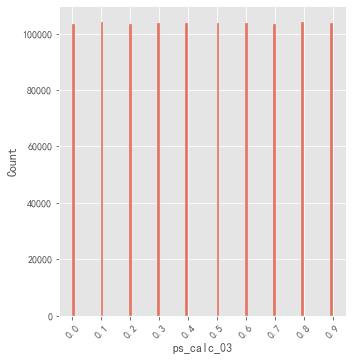

In [35]:
for col in continuous_cols:
    sns.displot(fullset[col])
    plt.xticks(ticks = np.linspace(start = fullset[col].min(),
                                  stop = fullset[col].max(),
                                  num = 10),rotation = 45)

In [36]:
def woe_iv_encoding(data, feat, target, max_intervals, verbose = False):
    
    feat_bins = pd.qcut(x = data[feat], q = max_intervals, duplicates='drop')
    gi = pd.crosstab(feat_bins,data[target])
    gb = pd.Series(data=data[target]).value_counts()

    bad = gi[1]/gi[0]
    good = gb[1]/gb[0]

    # 计算woe
    woe = np.log(bad) - np.log(good)

    # 计算iv
    iv = (bad-good)*woe

    # 计算整个特征的iv
    f_iv = iv.sum()  # 5.2958917587905745
    if verbose == True:
        print(f"根据当前的间隔数{max_intervals}，特征{feat}所计算的总information value为：{f_iv}")
        print('='*80)

    # 进行映射操作
    dic = iv.to_dict()

    iv_bins = feat_bins.map(dic)  # 连续型变量离散化

    return iv_bins.astype('float64')

![](https://miro.medium.com/max/1156/1*5S_5aAHWe0_knDGZUK3W8w.png)

In [37]:
for col in continuous_cols:
    fullset[f"{col}_woe"] = woe_iv_encoding(data = fullset, feat = col, target = 'target', max_intervals = 20)
    #sns.displot(fullset_copy[f"{col}_woe"])

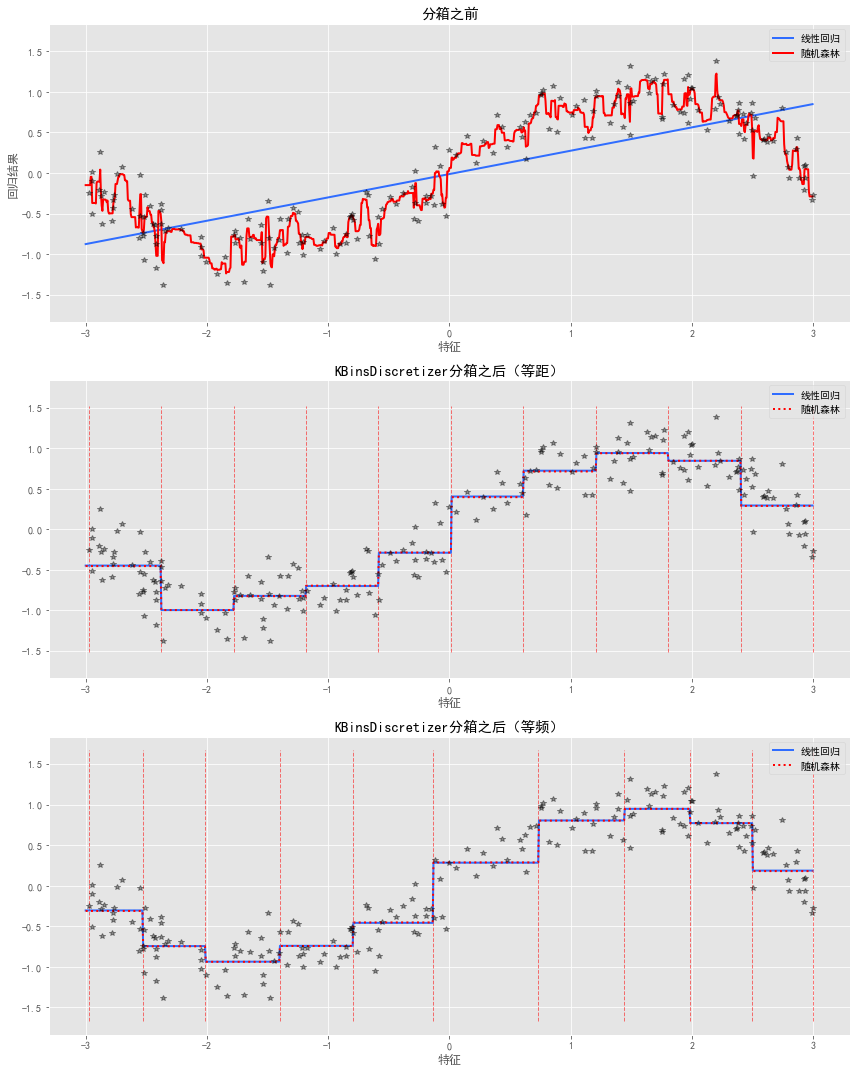

In [38]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor

# construct the dataset
rnd = np.random.RandomState(2022)
X = rnd.uniform(-3, 3, size=200)
y = np.sin(X) + rnd.normal(size=len(X)) / 4
X = X.reshape(-1, 1)

# transform the dataset with KBinsDiscretizer
enc1 = KBinsDiscretizer(n_bins=10, encode="onehot", strategy = 'uniform')
enc2 = KBinsDiscretizer(n_bins=10, encode="onehot", strategy = 'quantile')
X_binned_unif = enc1.fit_transform(X)
X_binned_quan = enc2.fit_transform(X)

# predict with original dataset
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1,nrows = 3, sharey=True, figsize=(12,5*3))
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = LinearRegression().fit(X, y)


ax1.plot(line, reg.predict(line), linewidth=2, color="#306dff", label="线性回归")
reg = RandomForestRegressor(random_state=0).fit(X, y)
ax1.plot(line, reg.predict(line), linewidth=2, color="red", label="随机森林")
ax1.plot(X[:, 0], y, "*", c="k",alpha = .4)
ax1.legend(loc="best")
ax1.set_ylabel("回归结果")
ax1.set_xlabel("特征")
ax1.set_title("分箱之前")

# predict with transformed dataset
line_binned_unif = enc1.transform(line)
reg = LinearRegression().fit(X_binned_unif, y)
ax2.plot(
    line,
    reg.predict(line_binned_unif),
    linewidth=2,
    color="#306dff",
    linestyle="-",
    label="线性回归",
)

reg = RandomForestRegressor(random_state=0).fit(X_binned_unif, y)
ax2.plot(
    line,
    reg.predict(line_binned_unif),
    linewidth=2,
    color="red",
    linestyle=":",
    label="随机森林",
)
ax2.plot(X[:, 0], y, "*", c="k", alpha = .4)
ax2.vlines(enc1.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1,alpha= .6, color = '#fc1b1b',linestyles = '--')
ax2.legend(loc="best")
ax2.set_xlabel("特征")
ax2.set_title("KBinsDiscretizer分箱之后（等距）")

# predict with transformed dataset
line_binned_quan = enc2.transform(line)
reg = LinearRegression().fit(X_binned_quan, y)
ax3.plot(
    line,
    reg.predict(line_binned_quan),
    linewidth=2,
    color="#306dff",
    linestyle="-",
    label="线性回归",
)

reg = RandomForestRegressor(random_state=0).fit(X_binned_quan, y)
ax3.plot(
    line,
    reg.predict(line_binned_quan),
    linewidth=2,
    color="red",
    linestyle=":",
    label="随机森林",
)
ax3.plot(X[:, 0], y, "*", c="k", alpha = .4)
ax3.vlines(enc2.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha= .6, color = '#fc1b1b',linestyles = '--')
ax3.legend(loc="best")
ax3.set_xlabel("特征")
ax3.set_title("KBinsDiscretizer分箱之后（等频）")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success"><b>Step 5</b>: 
    
- 根据上图，完善代码！
- 请叙述 pd.qcut 和 pd.cut 的区别，我们在变量离散化时用哪个更好？
- pd.qcut 和 pd.cut 和 KBinsDiscretizer 的区别？
- 根据这个例子你有什么启发？（开放）
    
</div>

In [39]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

interactions = pd.DataFrame(data=poly.fit_transform(fullset[continuous_cols]), 
                            columns=poly.get_feature_names_out(continuous_cols))


interactions.drop(continuous_cols, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('特征交互前，训练集有 {}个变量 '.format(fullset.shape[1]))
fullset = pd.concat([fullset, interactions], axis=1)
print('特征交互后，训练集有 {}个变量'.format(fullset.shape[1]))

特征交互前，训练集有 67个变量 
特征交互后，训练集有 112个变量


### PCA


PCA执行中...
Total Explained variance: 0.9948


Text(0, 0.5, '第二主成分解释 2.5 % 方差')

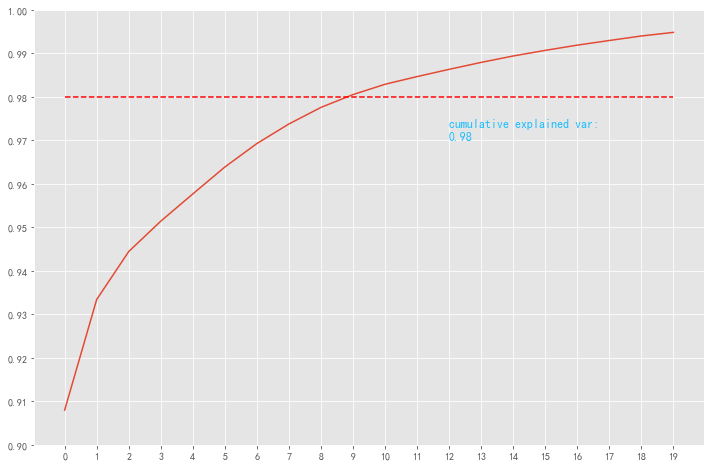

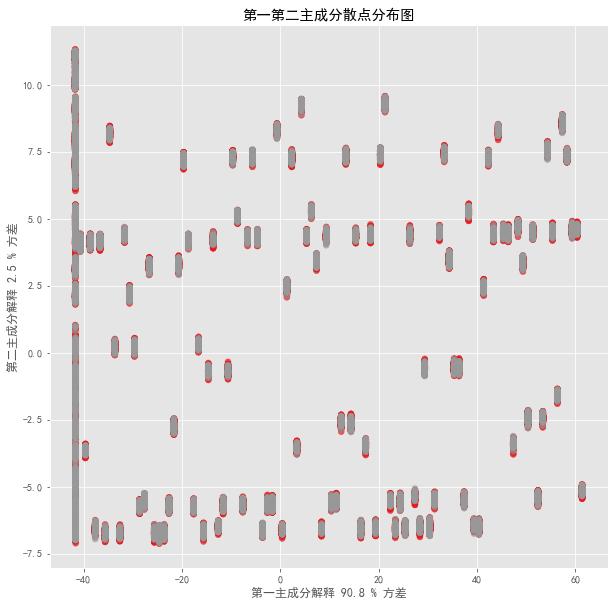

In [40]:
from sklearn.decomposition import PCA

X = train.drop(['id', 'target'], axis=1)
y = train.target

n_comp = 20
print('\nPCA执行中...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X)
print('Total Explained variance: %.4f' % pca.explained_variance_ratio_.sum())


plt.figure(figsize = [12,8])

pd.Series(pca.explained_variance_ratio_).cumsum().plot()

plt.plot(range(n_comp),[0.98]*20, 'r--')
plt.xticks(ticks = range(n_comp))
plt.yticks(ticks = np.linspace(0.9,1,11))
plt.text(12,0.97,'cumulative explained var: \n0.98',fontsize = 12, color = '#20beff')

plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='Set1',alpha = .7)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title(
        "第一第二主成分散点分布图")
plt.xlabel("第一主成分解释 %.1f %% 方差" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("第二主成分解释 %.1f %% 方差" % (
        pca.explained_variance_ratio_[1] * 100.0))

### GBDT+LR

## Selection

### Based on statistical indicators

In [41]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
selector.fit(fullset.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = fullset.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))

19 variables have too low variance.


### Model-Based Metrics

In [42]:
from xgboost import XGBClassifier
from xgboost import plot_importance

plt.figure(figsize = [100,20])

X = fullset.loc[train.index].drop(['id', 'target'], axis=1)
y = fullset.loc[train.index].target

model = XGBClassifier()

model.fit(X, y)
# plot feature importance

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<Figure size 7200x1440 with 0 Axes>

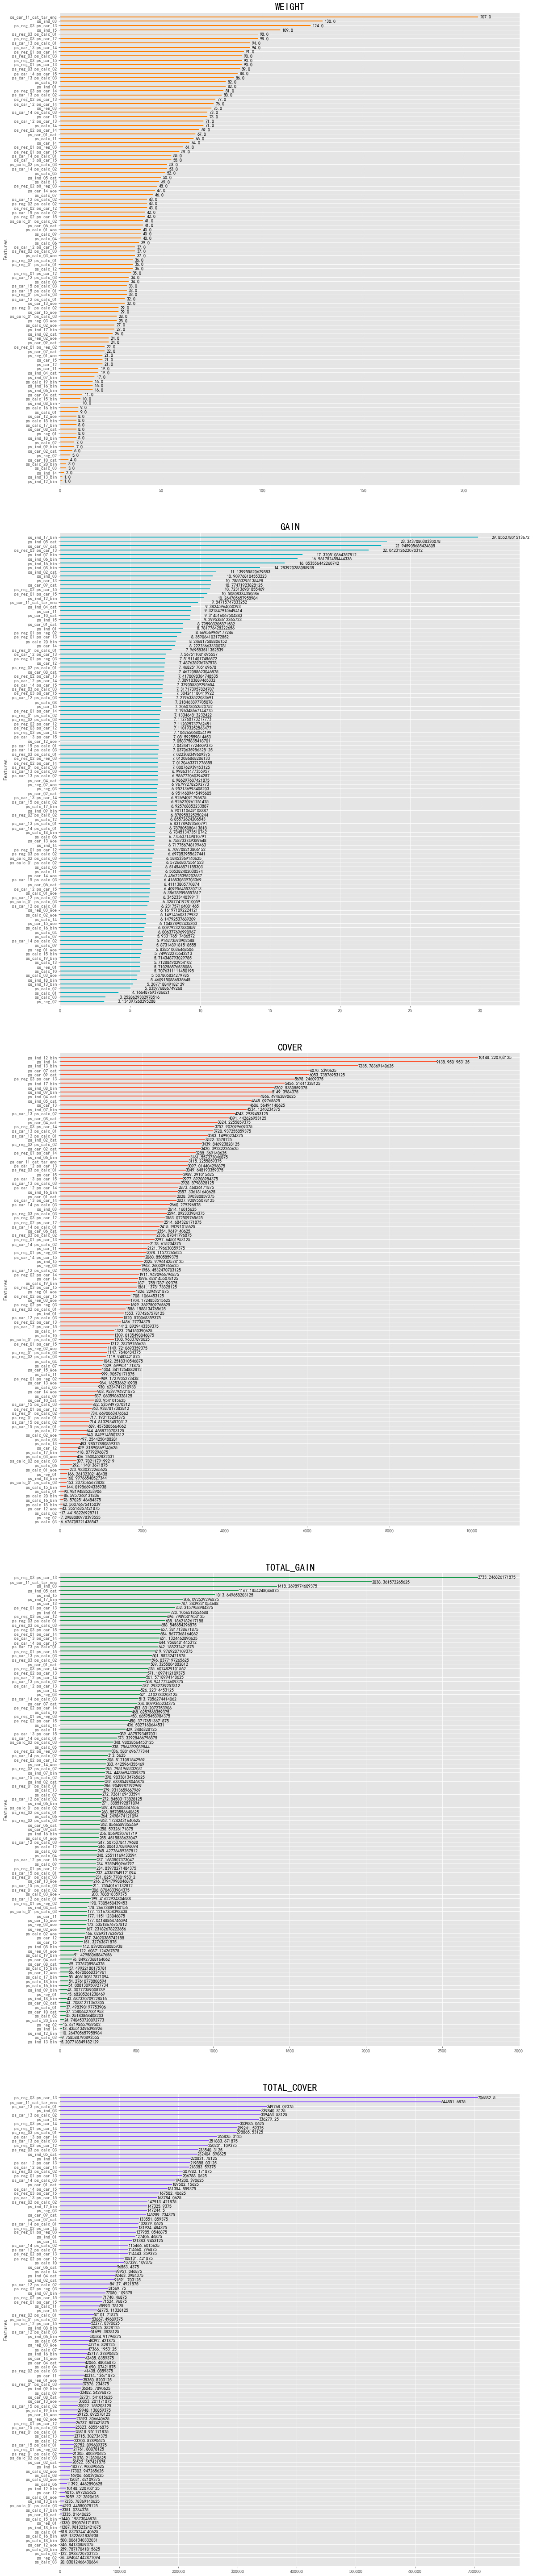

In [43]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 80))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
# loop through tickers and axes
colors = ['#ff7f01','#08aebd','#fc5531','#139948','#8950fe']
for ty, ax, color in zip(types, axs.ravel(), colors):
    # filter df for ticker and plot on specified axes
    plot_importance(ax = ax, booster = model,importance_type=ty, color = color)

    # chart formatting
    ax.set_title(ty.upper(),fontsize = 22)
    ax.set_xlabel("")

plt.show()

In [44]:
# 特征工程的strategy作为key，对应的变量名组成的list作为value
from sklearn.feature_selection import SelectFromModel
feat_dict = {}
for thres in ['median','mean','1.25*mean']:
    model_select = SelectFromModel(model, threshold=thres, prefit=True)
    print(f'筛选前总计：{X.shape[1]}个特征')
    n_features = model_select.transform(X.values).shape[1]
    print(f'筛选后总计： {n_features}个特征【{thres}】')
    print('#'*60)
    selected_vars = list(X.columns[model_select.get_support()])
    feat_dict[thres] = selected_vars

筛选前总计：110个特征
筛选后总计： 55个特征【median】
############################################################
筛选前总计：110个特征
筛选后总计： 27个特征【mean】
############################################################
筛选前总计：110个特征
筛选后总计： 15个特征【1.25*mean】
############################################################


In [45]:
for ty in types:
    feat_dict[ty] = list(model.get_booster().get_score(importance_type=ty).keys())

In [46]:
final_train = fullset.loc[train.index][feat_dict['mean']+['target']]
final_test = fullset.loc[test.index][feat_dict['mean']]

In [47]:
final_train.to_csv("final_train.csv")
final_test.to_csv("final_test.csv")